# Tutorial 3: Initializing a large-scale chain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC as MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
import cmocean

C:\Users\allyn\miniforge3\envs\gstatsMCMC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lets first load the dataset, variables, and do normal score transformation to calculate the variogram

In [2]:
# load compiled bed elevation measurements
df = pd.read_csv('RutfordDataGridded.csv')

In [3]:
rng_seed = 23198104

In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [6]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [7]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmap topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(np.float64(-1425500.0),
 np.float64(-1225500.0),
 np.float64(80000.0),
 np.float64(197000.0))

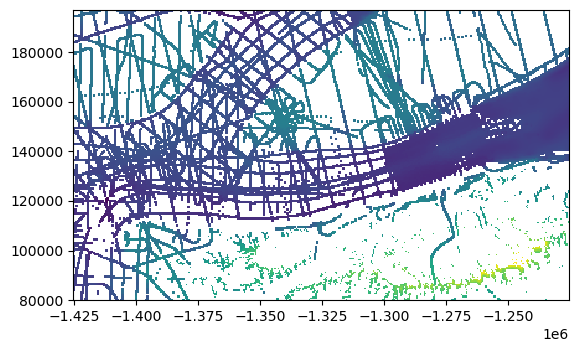

In [8]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [9]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=rng_seed).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

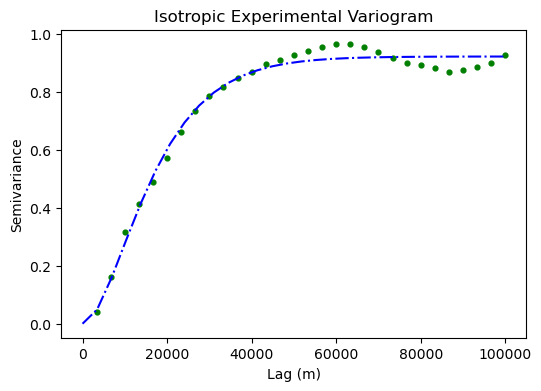

In [10]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=rng_seed)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [11]:
V1_p

[np.float64(43384.81483207828),
 np.float64(0.9222805005263003),
 np.float64(1.6697503379133176),
 0]

I recommend to find the variogram parameters (V1_p) once and keep using it with all the chains you run in this region.

save the value for later documentation purpose

In [12]:
V1_p = [44882.83153571452, 0.9250690010714218, 1.0048279843651087, 0]
 #[range, sill, shape, nugget]

In [13]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('Rutford_sgs_bed_0.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the large scale chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [14]:
# mask where True means grounded ice, False means ice-free land/ice-shelf/ocean
grounded_ice_mask = (bedmap_mask == 1)

In [15]:
largeScaleChain = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


Now, the object 'largeScaleChain' have all the properties you have assigned in the initialization process. Try typing *largeScaleChain.xx* or *largeScaleChain.cond_bed*, or any other argument to check them.

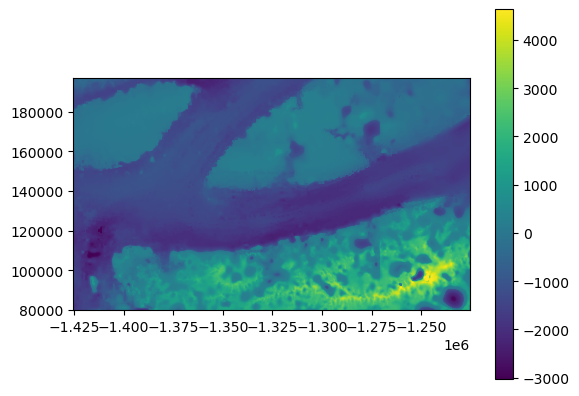

In [16]:
plt.pcolormesh(xx, yy, largeScaleChain.initial_bed)
plt.axis('scaled')
plt.colorbar()

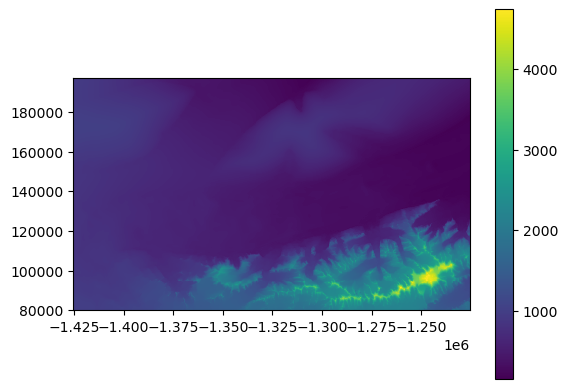

In [17]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

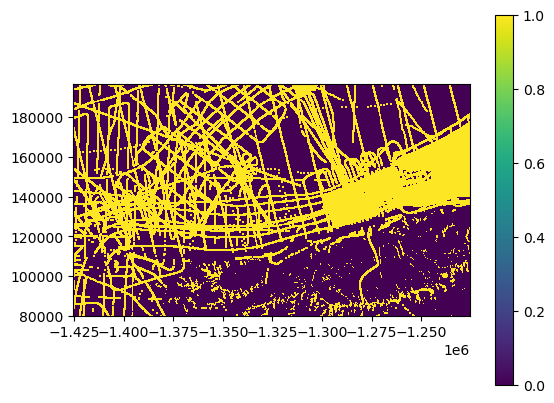

In [18]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

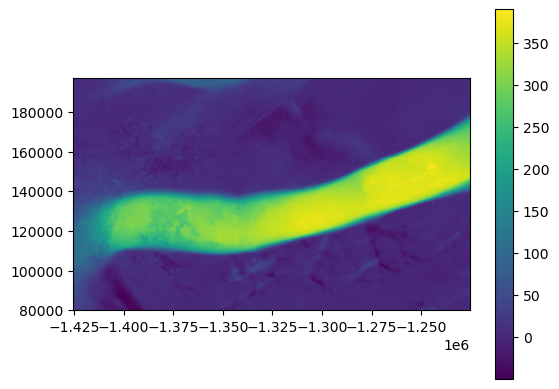

In [19]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

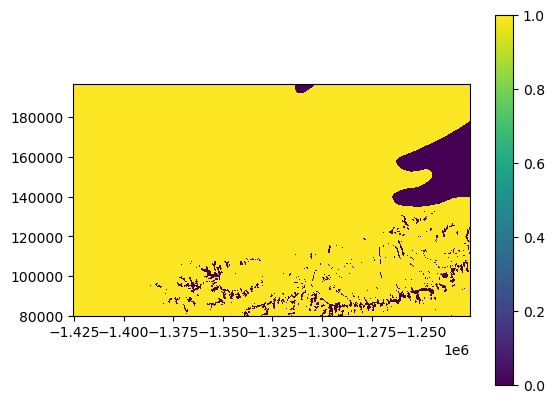

In [20]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

The second function required, is *set_update_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [21]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


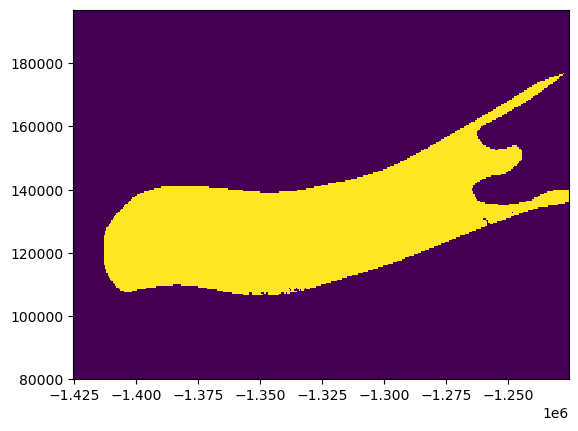

In [22]:
plt.pcolormesh(xx,yy,highvel_mask)

We also want to specify how we want to define the loss function used in the chain.

__For simplification, I disabled some functions originally used in the class.__ The mass conservation residuals are only calculated by 'sum square', which represent it as a Gaussian random variable. No different to radar measurements are calculated, since both update preserve radar measurements. Therefore, there is no need to define 'diff_func', 'sigma_data', or 'dataDiffInRegion'.

The only argument 'sigma_mc' control the magnitude of the mass flux residuals, and massConvInRegion should be set to True to only calculate mass flux residuals inside the high velocity region.

In [23]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

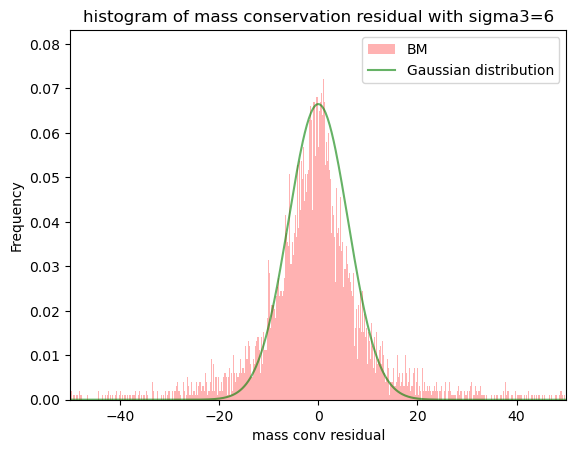

In [24]:
sigma3 = 6 #adjust to match BM the closest 
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual with sigma3=6')
plt.show()

In [25]:
largeScaleChain.set_loss_type(sigma_mc=6, massConvInRegion=True)

To directly calculate the loss of BedMachine topography in terms of mass conservation residuals, we can directly calls:

largeScaleChain.loss(mass_conservation_residuals, difference_to_radar_measurements)

the _loss()_ function returns three values: the total loss, mass conservation loss (loss based on mass conservation residuals) and measurements data loss (loss based on differences between the topography and the radar measurements). The total loss equals mass conservation loss plus radar measurements loss.

Because we only set-up the mass conservation loss, the difference_to_radar_measurements can be left out

In [26]:
largeScaleChain.loss(mc_res_bm, 0)

(np.float64(45373.40404963231), np.float64(45373.40404963231), 0)

For more information regarding these two functions, please check the documentation for MCMC.py

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [27]:
#range_max and range_min changes topographies features' lateral scale
#by default, I set range_max to variogram range
range_max_x = 45e3 #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = 45e3
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 300
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

Before using the `RandField` object in an MCMC chain or for field generation, 
 call function `set_block_sizes` to initialize block size ranges; 
 call function `set_weight_param` to set up conditional weighting parameters; 
 call function 'set_generation_method' to set up method used to generate random fields.


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [28]:
min_block_x = 200
max_block_x = 300
min_block_y = 70
max_block_y = 150
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [29]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

Set the generation method using the original gstools random field generator or the spectral synthesis generator.

In [30]:
rf1.set_generation_method(spectral=True)

### Large Scale Chain with Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [31]:
largeScaleChain.set_crf_data_weight(rf1)
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


In [32]:
np.savetxt('data_weight_Rutford_0.txt', largeScaleChain.crf_data_weight)

The data weight is controlled by the logistic parameters passed in the 'set_weight_param()' function. If you change any argument to that function, call 'set_crf_data_weight()' again. Otherwise, feel free to use the saved data weight file.

In [33]:
largeScaleChain.crf_data_weight = np.loadtxt('data_weight_Rutford_0.txt')
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


'set_random_generator' set up a random generator for the chain. You can pass an int as a seed or pass a random number generator directly. If no rng_seed is passed in, then the random number generator will randomly decided.

Please save the seed you used for reproducibility purpose.

In [34]:
largeScaleChain.set_random_generator(rng_seed = rng_seed)

### With 500 iterations

And then we can start the chain by specifying how many iterations it should go through

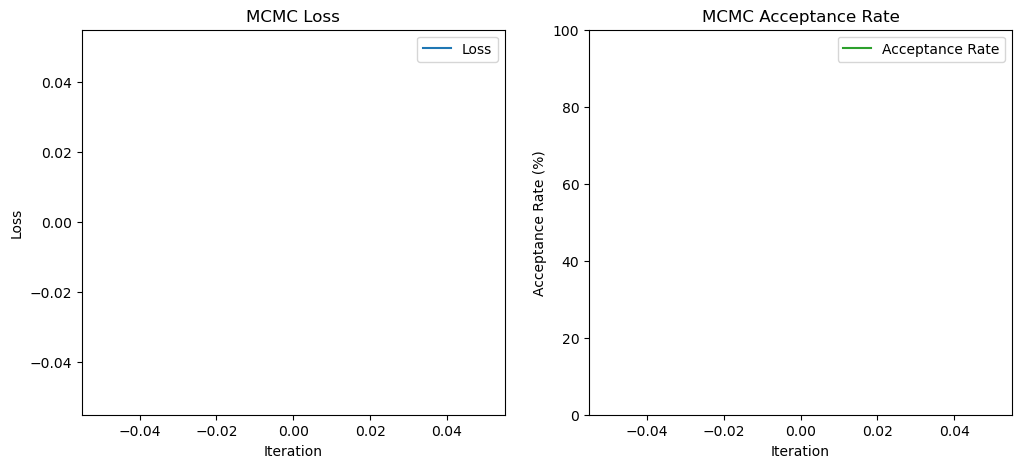

Chain 0 | Seed Unknown: 100%|█| 99/99 [00:00<00:00, 160.24it/s, chain_id=0, seed=Unknown, mc loss=1.738e+05, data loss=


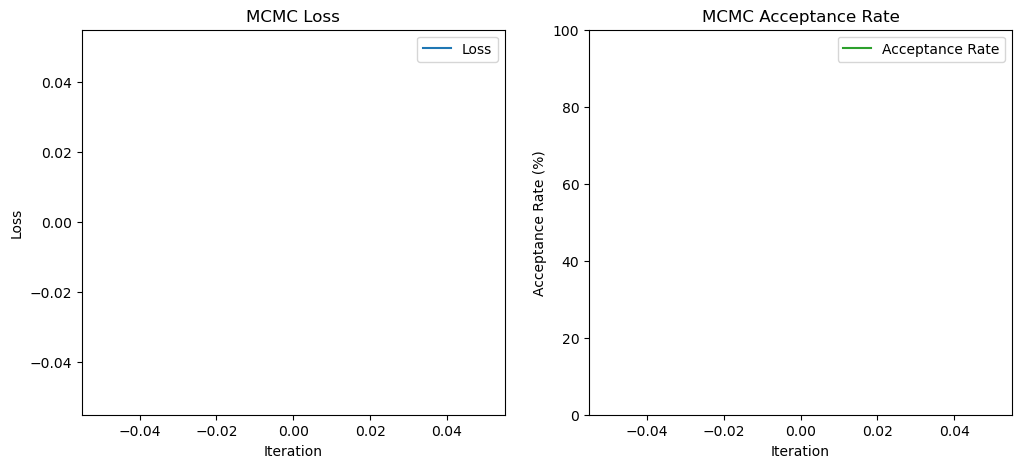

Chain 0 | Seed Unknown: 100%|█| 99/99 [00:01<00:00, 94.00it/s, chain_id=0, seed=Unknown, mc loss=1.730e+05, data loss=0


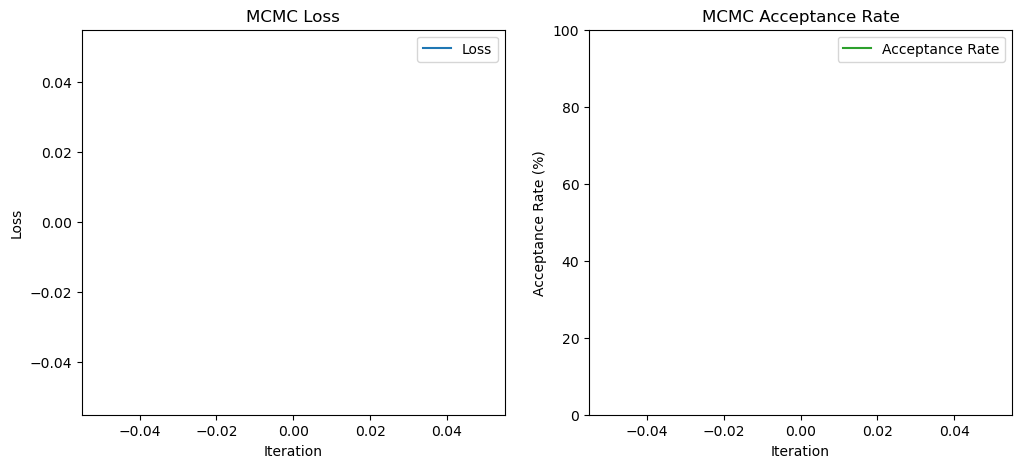

Chain 0 | Seed Unknown: 100%|█| 99/99 [00:01<00:00, 87.60it/s, chain_id=0, seed=Unknown, mc loss=1.721e+05, data loss=0


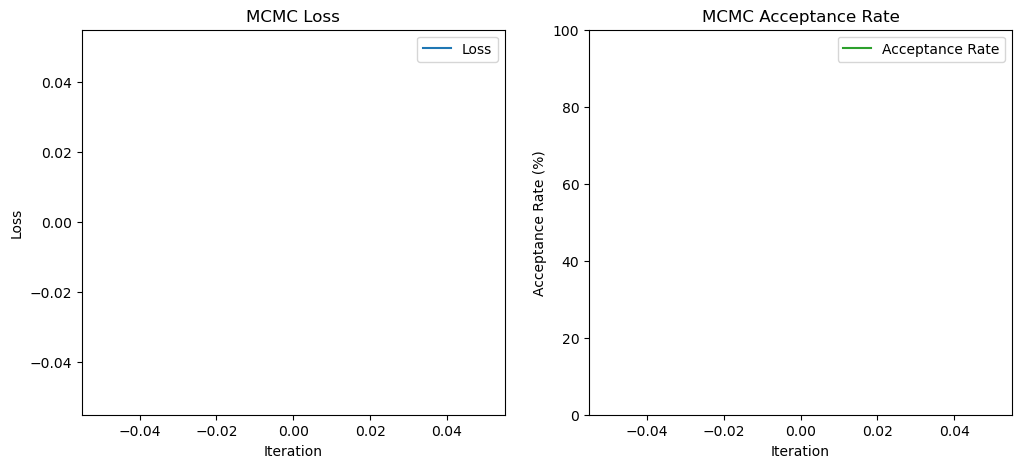

Chain 0 | Seed Unknown: 100%|█| 99/99 [00:01<00:00, 94.00it/s, chain_id=0, seed=Unknown, mc loss=1.719e+05, data loss=0


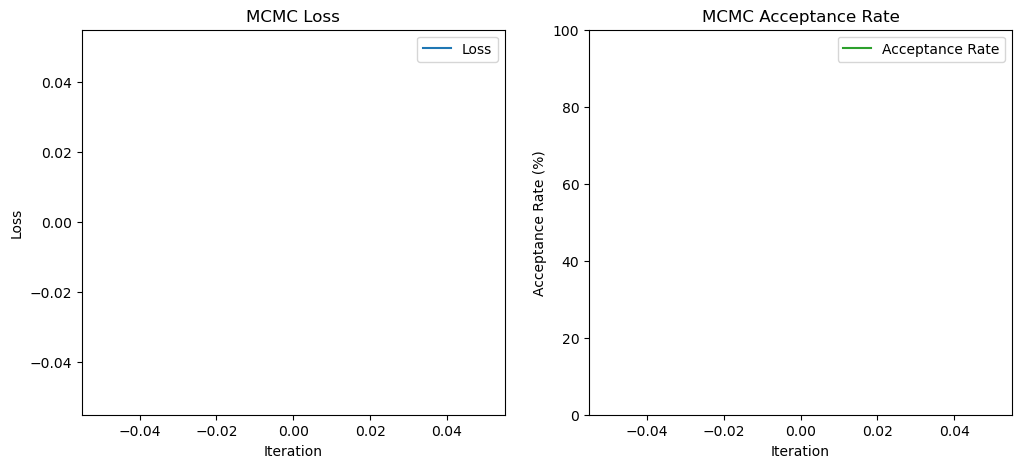

Chain 0 | Seed Unknown: 100%|█| 99/99 [00:01<00:00, 89.49it/s, chain_id=0, seed=Unknown, mc loss=1.716e+05, data loss=0


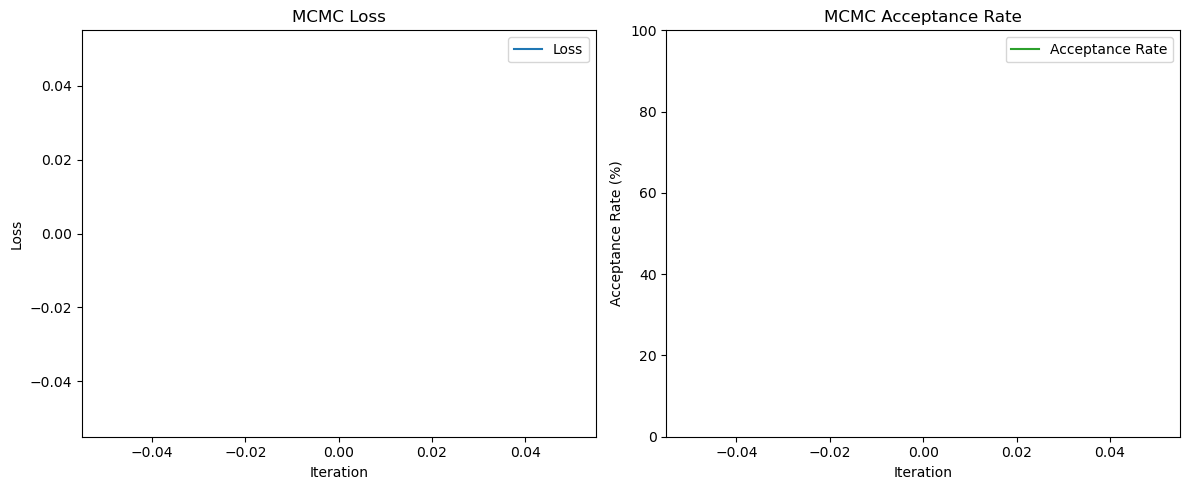

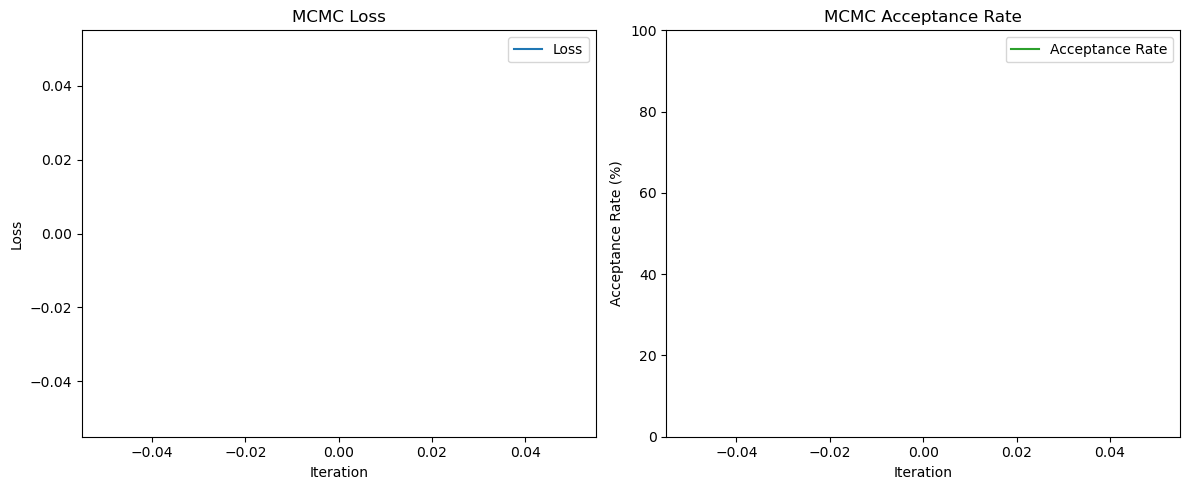

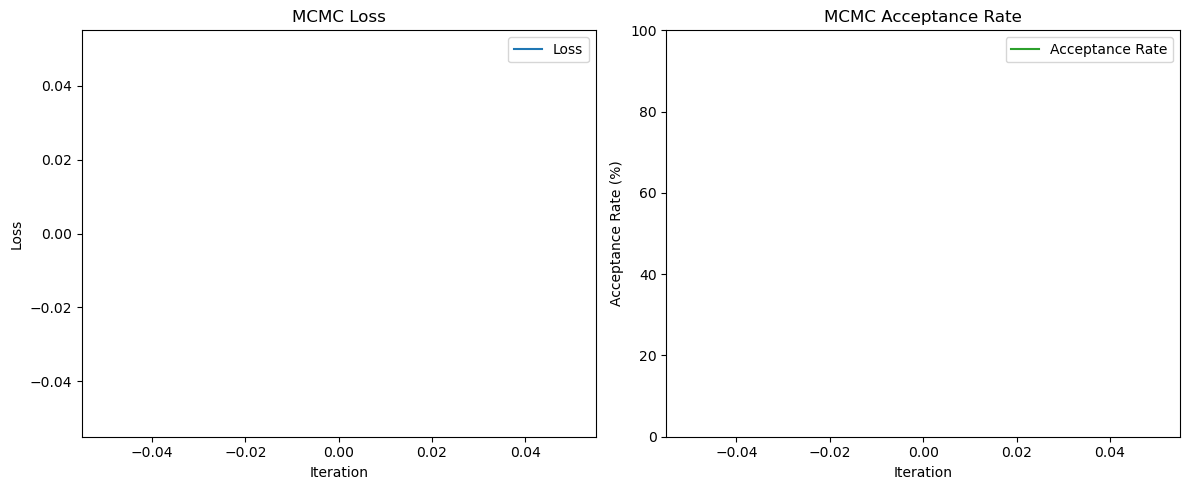

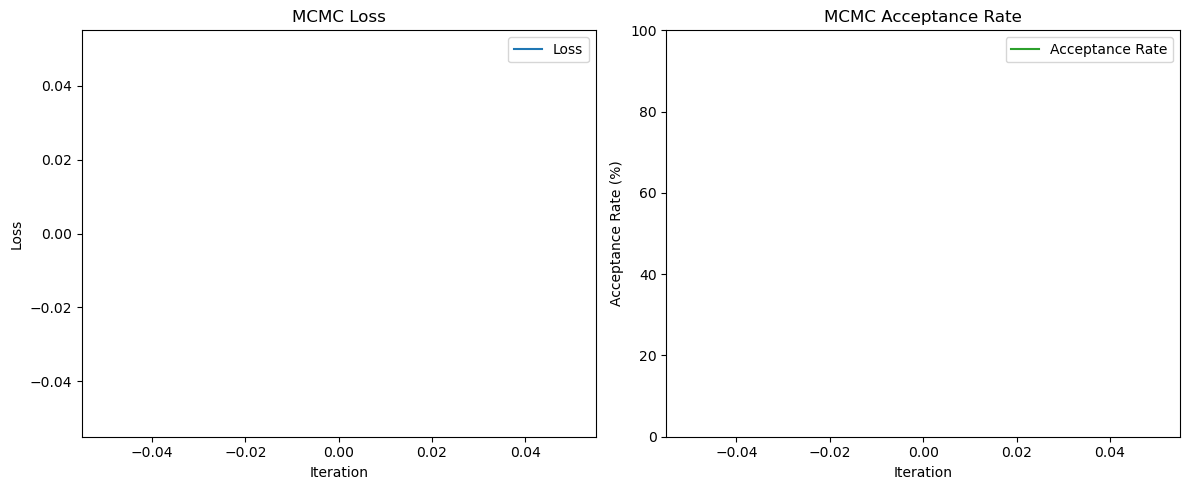

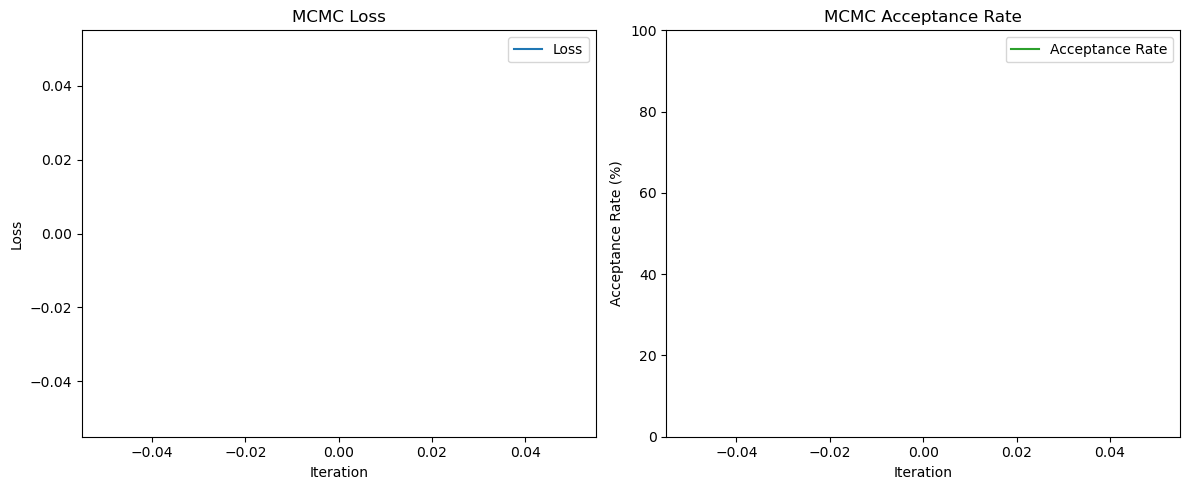

In [35]:
n_iter = 100 #how often chain is saved
n_segment = 5 #how many n_iters run
# number of iternations equals n_iter*n_segment

for i in range(0,n_segment):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=n_iter, RF=rf1, only_save_last_bed=False)
    
    # save all the data in every run of the algorithm
    np.savetxt('Rutford_loss_'+str(i*n_iter)+'.txt', loss)
    np.savetxt('Rutford_steps_'+str(i*n_iter)+'.txt', steps) 
    np.savetxt('Rutford_beds_'+str(i*n_iter)+'.txt',beds.reshape((n_iter, beds.shape[1]*beds.shape[2])))
    
    # set up the next chain
    largeScaleChain.initial_bed = beds[-1,:,:]

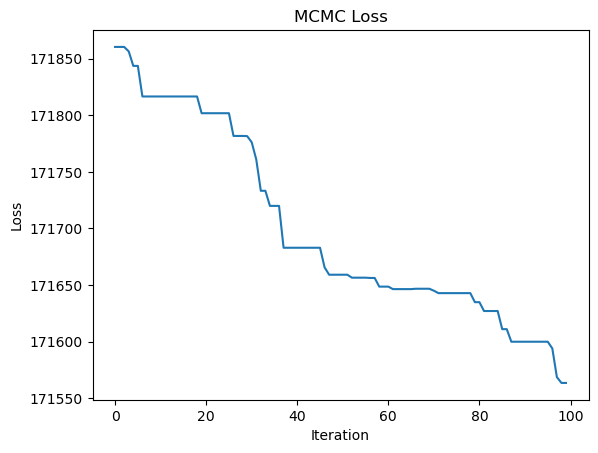

In [36]:
plt.plot(loss)
plt.xlabel('Iteration');
plt.ylabel('Loss');
plt.title('MCMC Loss')
plt.show()

### With 5000 Iterations

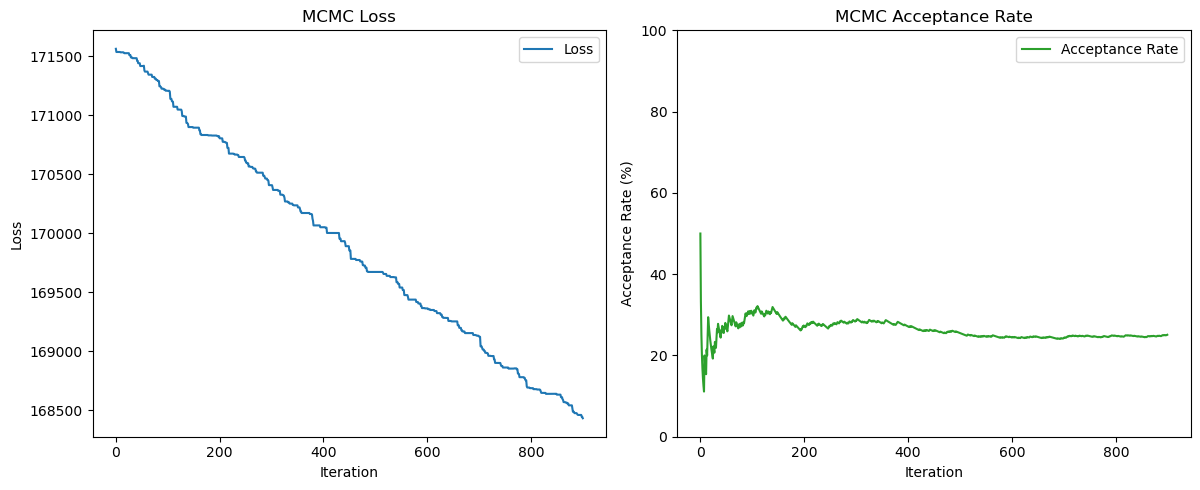

Chain 0 | Seed Unknown: 100%|█| 999/999 [00:12<00:00, 78.50it/s, chain_id=0, seed=Unknown, mc loss=1.682e+05, data loss


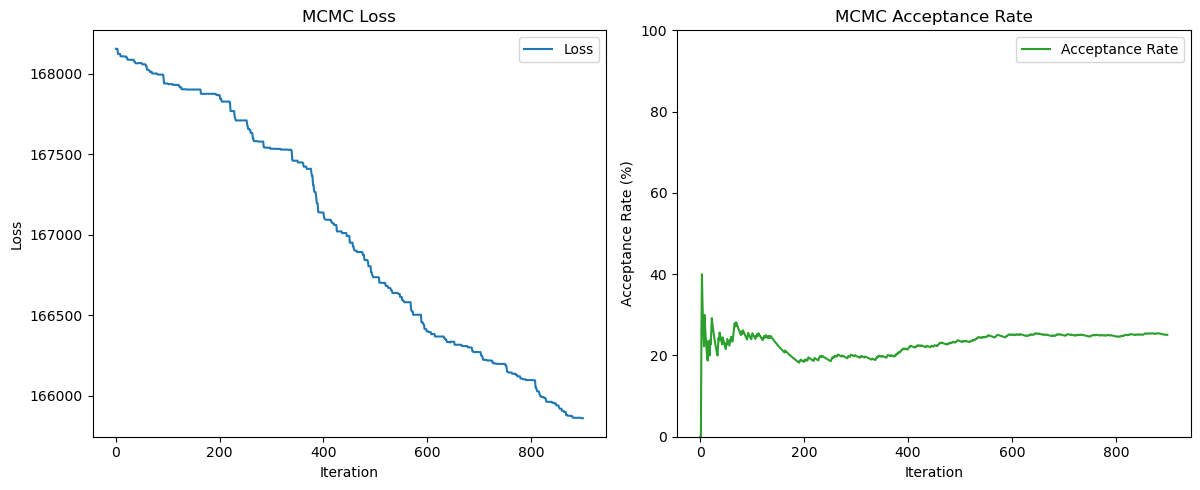

Chain 0 | Seed Unknown: 100%|█| 999/999 [00:09<00:00, 110.90it/s, chain_id=0, seed=Unknown, mc loss=1.656e+05, data los


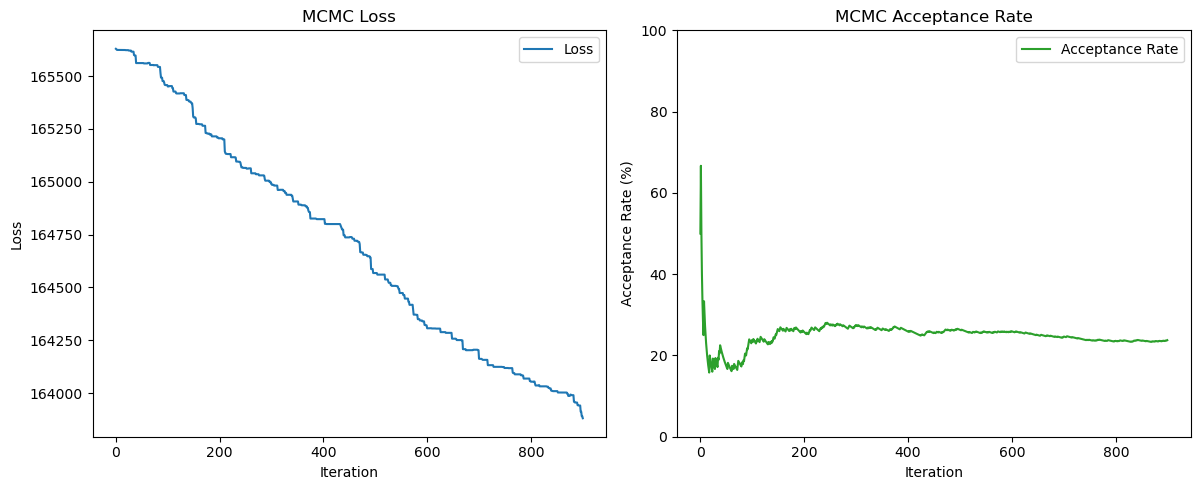

Chain 0 | Seed Unknown: 100%|█| 999/999 [00:15<00:00, 62.90it/s, chain_id=0, seed=Unknown, mc loss=1.636e+05, data loss


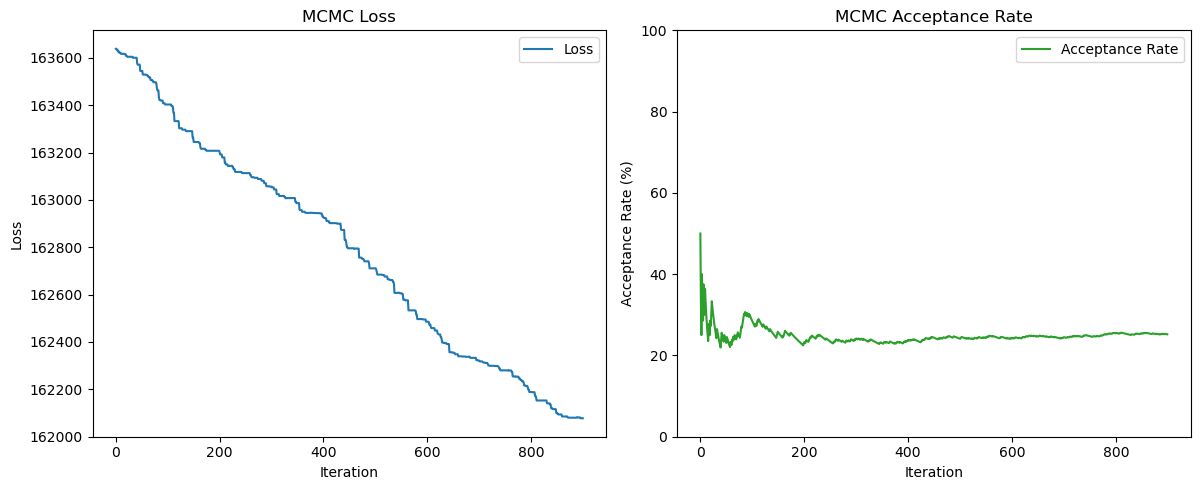

Chain 0 | Seed Unknown: 100%|█| 999/999 [00:08<00:00, 118.23it/s, chain_id=0, seed=Unknown, mc loss=1.619e+05, data los


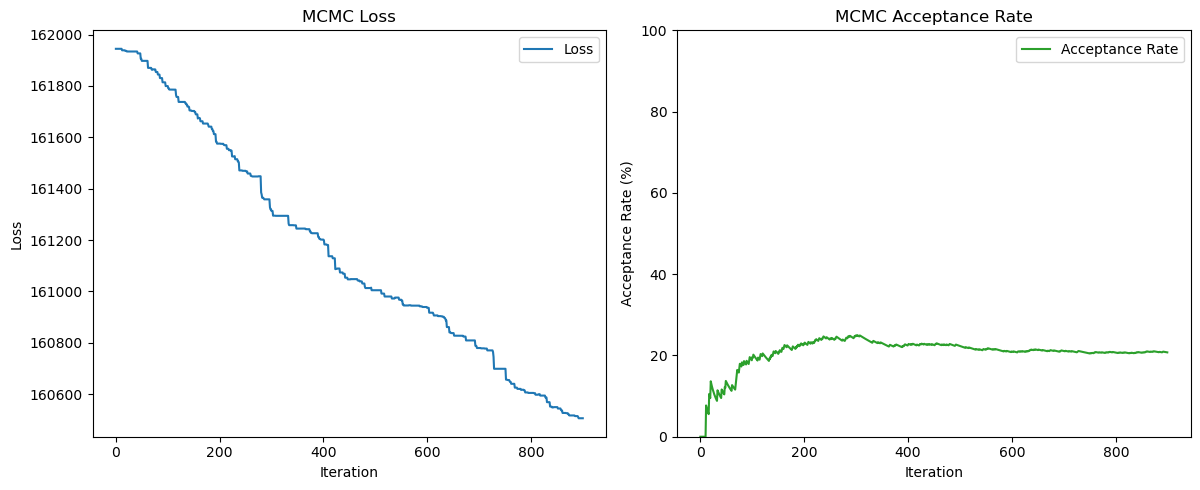

Chain 0 | Seed Unknown: 100%|█| 999/999 [00:13<00:00, 71.85it/s, chain_id=0, seed=Unknown, mc loss=1.604e+05, data loss


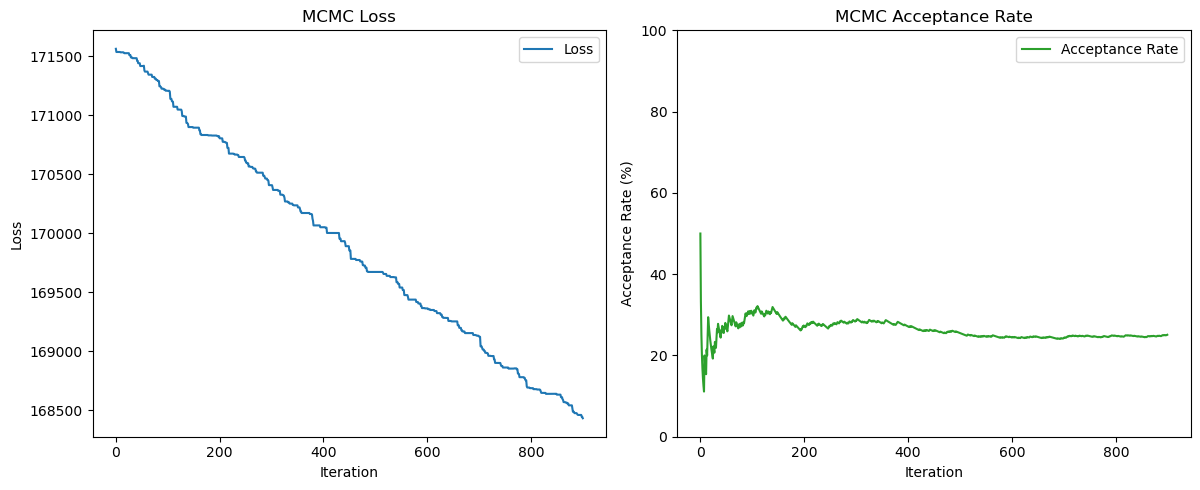

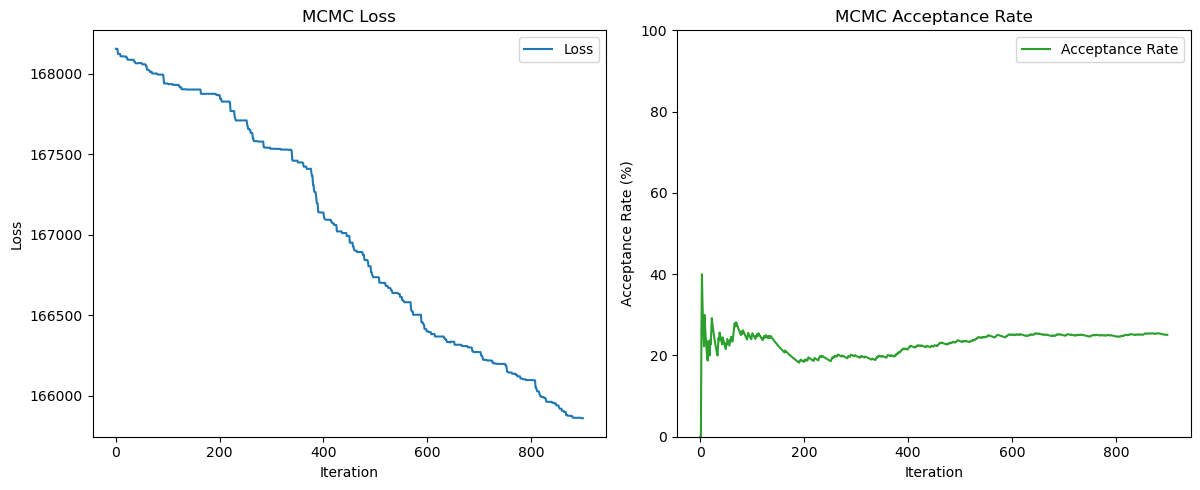

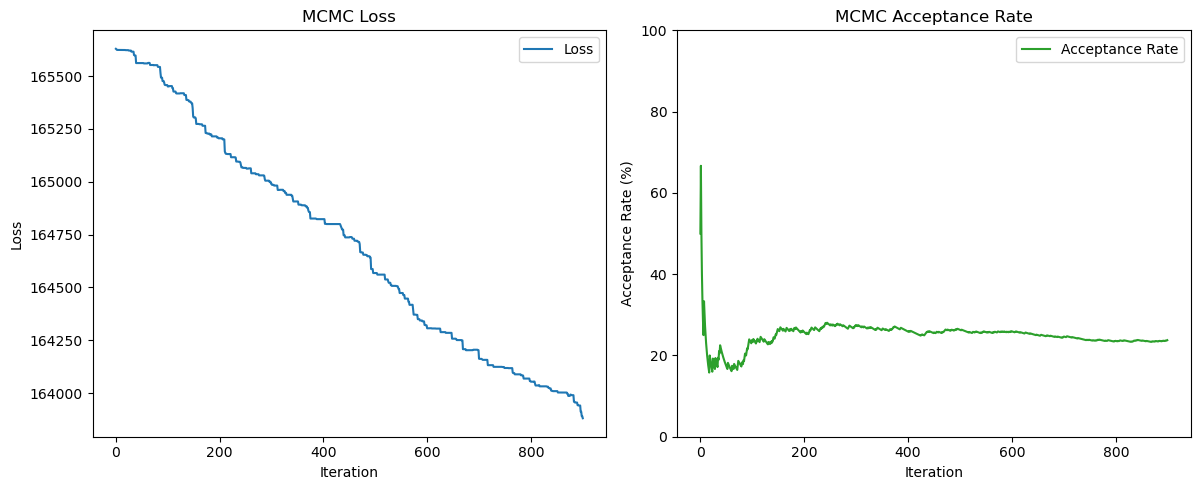

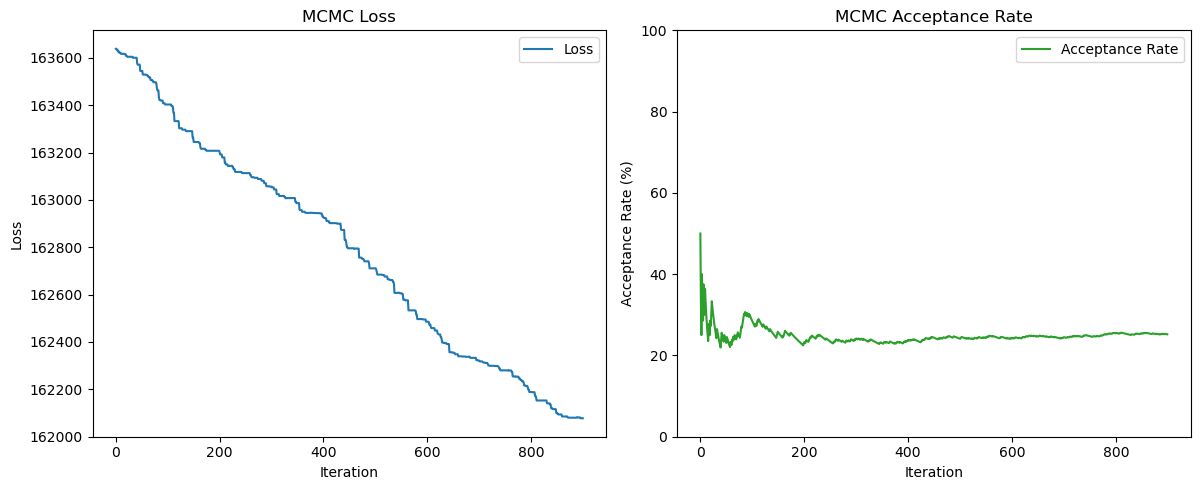

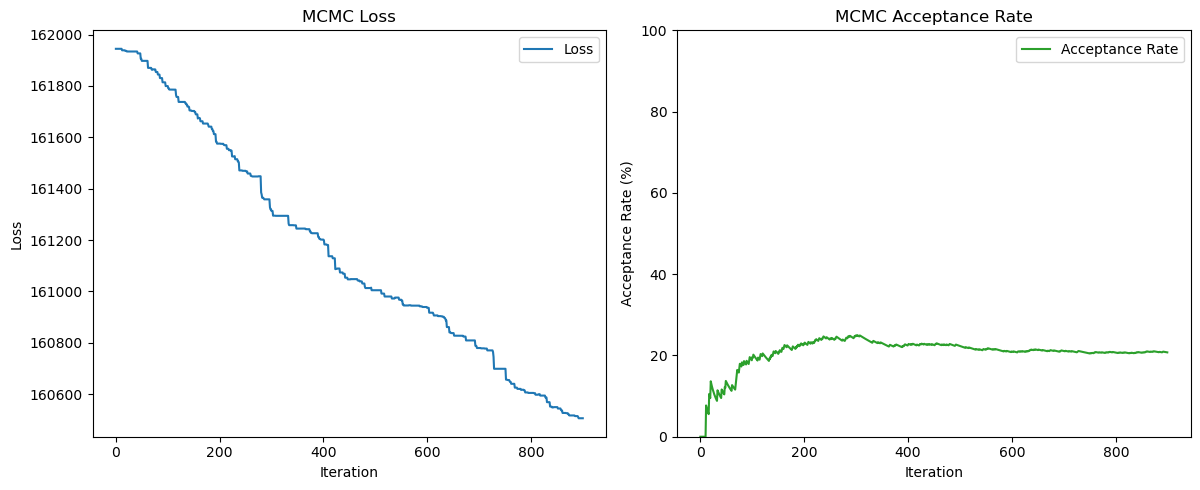

In [37]:
n_iter = 1000
n_segment = 5

for i in range(0,n_segment):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=n_iter, RF=rf1, only_save_last_bed=False)
    
    # save all the data in every run of the algorithm
    np.savetxt('Rutford_loss_'+str(i*n_iter)+'.txt', loss)
    np.savetxt('Rutford_steps_'+str(i*n_iter)+'.txt', steps) 
    np.savetxt('Rutford_beds_'+str(i*n_iter)+'.txt',beds.reshape((n_iter, beds.shape[1]*beds.shape[2])))
    
    # set up the next chain
    largeScaleChain.initial_bed = beds[-1,:,:]

### Verify Results

We can check several aspects of the results:

- How the topography deviate from radar measurements

- Mass flux residuals of the current topography

- How loss reduce over time

- Variogram of the simulated topography

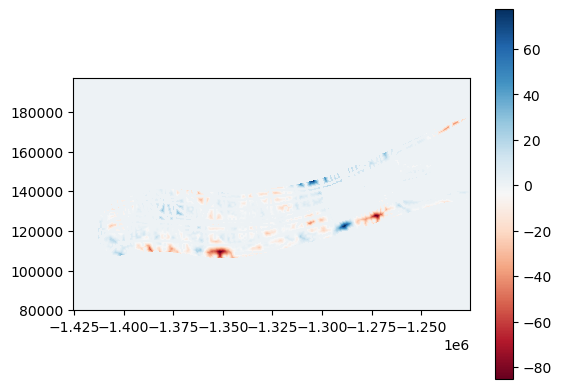

In [38]:
plt.pcolormesh(xx,yy,beds[-1]-beds[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

In [59]:
norm=plt.Normalize(vmin=-5000, vmax=5000)

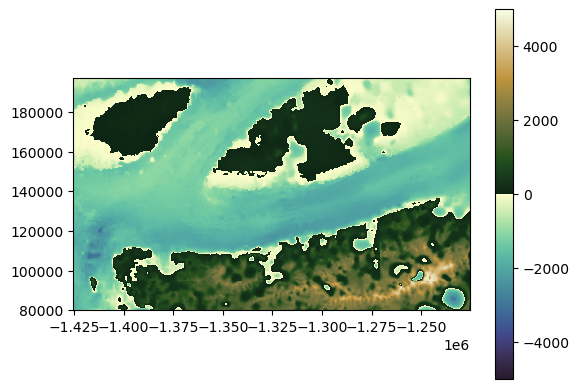

In [60]:
plt.pcolormesh(xx,yy,beds[0],cmap='cmo.topo',norm=norm)
plt.axis('scaled')
plt.colorbar()

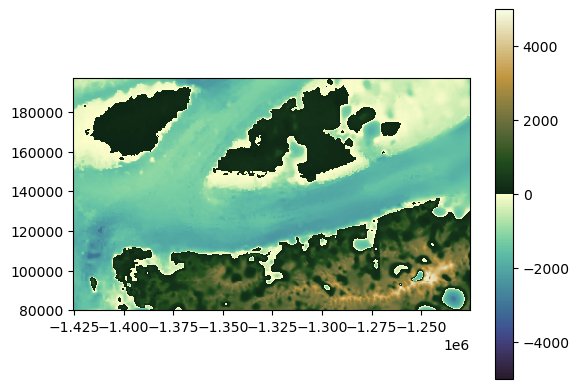

In [62]:
plt.pcolormesh(xx,yy,beds[-1],cmap='cmo.topo',norm=norm)
plt.axis('scaled')
plt.colorbar()

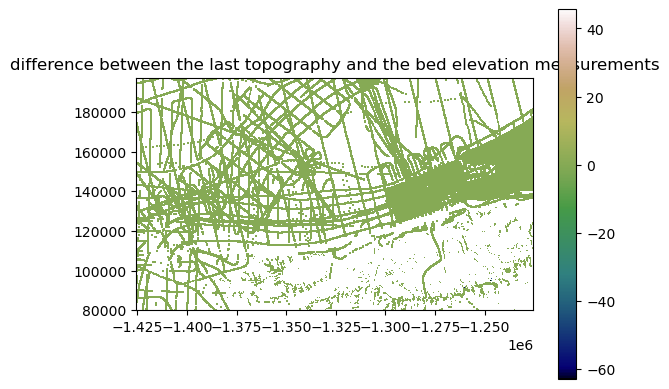

In [41]:
plt.pcolormesh(xx,yy,beds[-1] - cond_bed,cmap='gist_earth')
plt.title('difference between the last topography and the bed elevation measurements')
plt.axis('scaled')
plt.colorbar()

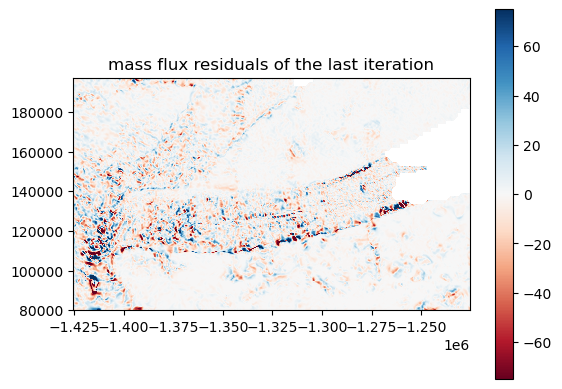

In [42]:
mass_flux_res = Topography.get_mass_conservation_residual(beds[-1],bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mass_flux_res,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of the last iteration')
plt.axis('scaled')
plt.colorbar()

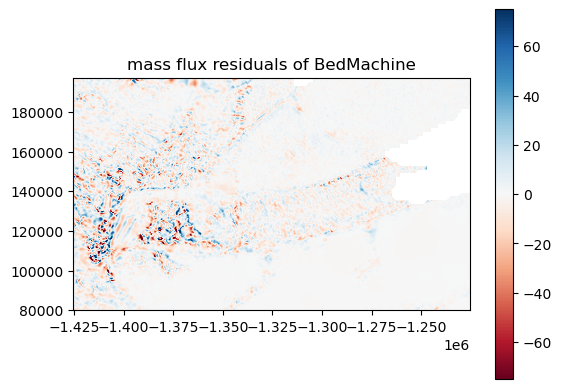

In [43]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mc_res_bm,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of BedMachine')
plt.axis('scaled')
plt.colorbar()

In [44]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_bedmachine

(np.float64(45373.40404963231), np.float64(45373.40404963231), 0)

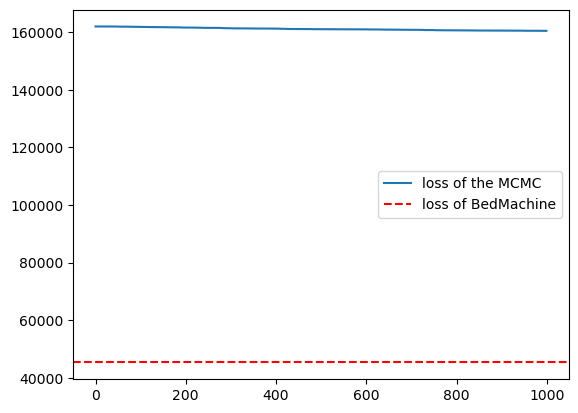

In [45]:
plt.plot(loss_mc,label='loss of the MCMC')
plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')
plt.legend()

In [46]:
df['simulated_topography'] = sgs_bed.flatten()

In [47]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["simulated_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
#values = df_sampled['simulated_topography']
values = df_sampled['simulated_topography']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_sim = V1.bins
ydata_sim = V1.experimental
V1_p = V1.parameters

In [48]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['cond_bed']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V2 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_cond = V2.bins
ydata_cond = V2.experimental
V2_p = V2.parameters

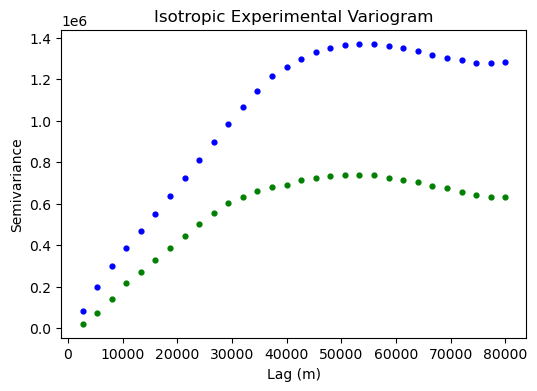

In [49]:
# compare experimental variogram
plt.figure(figsize=(6,4))
plt.scatter(xdata_sim, ydata_sim, s=12, c='b', label='variogram for simulated topography')
plt.scatter(xdata_cond, ydata_cond, s=12, c='g', label='variogram for radar measurements')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

### Save Results

Please remember to save the result for comparison later. For example, I always save the loss of every iteration, the acceptance rate (steps), and some topography.

For example, you can save the topography every 1000 iteration:

In [ ]:
beds.shape

In [ ]:
for i in range(0,10000,1000)
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run(n_iter=1000, RF=rf1)
    np.savetxt('loss_'+str(i)+'to'+str(i+1000), loss)
    np.savetxt('steps_'+str(i)+'to'+str(i+1000), steps) 
    np.savetxt('beds_at_' + str(i+1000) +'th_iteration',beds[-1])
    largeScaleChain.intial_bed =beds[-1]

Or you can save beds at more iterations. For the example, the code below save beds for every 100 iteration, while we are running the chain for 1000 iterations

In [ ]:
beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run(n_iter=1000, RF=rf1)
select_index = np.arange(0,1000,100)
np.savetxt("name,txt", beds[select_index,:,:].reshape(len(select_index), -1))

And these data can be loaded later and concatenated together to showcase the complete chain

A chain can be continued by assigning the initial bed

In [ ]:
largeScaleChain.initial_bed = beds[-1]

beds2, loss_mc2, loss_data2, loss2, steps2, resampled_times2, blocks_used2 = largeScaleChain.run(n_iter=5000, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)

In [ ]:
plt.pcolormesh(xx,yy,beds[-1] - beds2[0],cmap='viridis')
plt.axis('scaled')
plt.colorbar()

In [ ]:
plt.pcolormesh(xx,yy,beds2[-1]-beds2[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

In [ ]:
plt.pcolormesh(xx,yy,beds2[-1],cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()